# What is the most optimal skill to learn for Data Analysts?

### Methodology
1. Group skills to determine median salary and likelihood of being in posting
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevalent

In [1]:
# Importing Libraries
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import datetime as dt
import ast
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [ ]:
# Filtering and cleaning
df_DA_US = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Analyst')].copy()
df_DA_US.dropna(subset = ['salary_year_avg'], inplace = True)

total_jobs = len(df_DA_US)

# Exploding on job skills and creating a groupby based on median salary and count
df_DA_US_exploded = df_DA_US.explode('job_skills')
df_DA_US_group = df_DA_US_exploded.groupby('job_skills').agg(
    median_salary = ('salary_year_avg', 'median'),
    skill_count = ('job_skills', 'count')
).sort_values(by = 'skill_count', ascending= False)


# Creating a percent column and filtering based on highest demand jobs
df_DA_US_group['skill_perc'] = df_DA_US_group['skill_count']/total_jobs * 100
skill_percent = 5
df_DA_US_high_demand = df_DA_US_group[df_DA_US_group['skill_perc'] > skill_percent]


df_DA_US_high_demand

4350


,median_salary,skill_count,skill_perc
job_skills,,,
sql,91000.00,2508,57.655172
excel,84392.00,1808,41.563218
python,97500.00,1431,32.896552
tableau,92875.00,1364,31.356322
sas,90000.00,926,21.287356
r,92500.00,893,20.528736
power bi,90000.00,838,19.264368
powerpoint,85000.00,462,10.620690
word,81194.75,461,10.597701


In [34]:
# Categorising skills
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

df_technology = pd.DataFrame(list(technology_dict.items()), columns = ['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_plot = df_DA_US_high_demand.merge(df_technology, left_on = 'job_skills', right_on = 'skills')

df_plot

,median_salary,skill_count,skill_perc,technology,skills
0,91000.00,2508,57.655172,programming,sql
1,84392.00,1808,41.563218,analyst_tools,excel
2,97500.00,1431,32.896552,programming,python
3,92875.00,1364,31.356322,analyst_tools,tableau
4,90000.00,926,21.287356,analyst_tools,sas
5,90000.00,926,21.287356,programming,sas
6,92500.00,893,20.528736,programming,r
7,90000.00,838,19.264368,analyst_tools,power bi
8,85000.00,462,10.620690,analyst_tools,powerpoint
9,81194.75,461,10.597701,analyst_tools,word


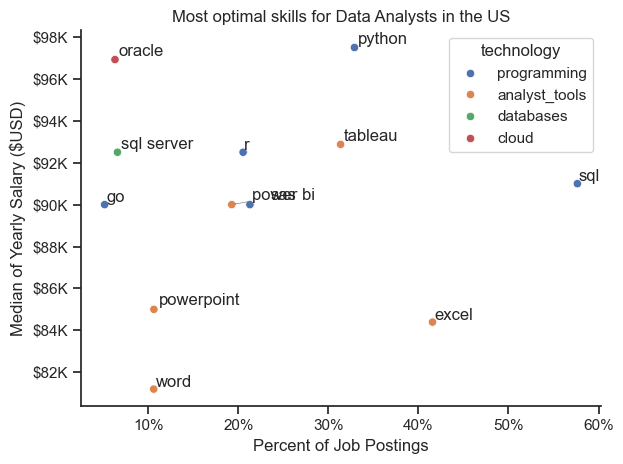

In [47]:
from adjustText import adjust_text

sns.scatterplot(data = df_plot, x = 'skill_perc', y = 'median_salary', hue = 'technology')

sns.despine()
sns.set_theme(style = 'ticks')

texts = []
for i, txt in enumerate(df_DA_US_high_demand.index):
    texts.append(plt.text(df_DA_US_high_demand['skill_perc'].iloc[i], df_DA_US_high_demand['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'gray', lw = 0.5)) # Meant to space out scatter labels


ax = plt.gca()
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals = 0))

plt.xlabel('Percent of Job Postings')
plt.ylabel('Median of Yearly Salary ($USD)')
plt.title('Most optimal skills for Data Analysts in the US')
plt.tight_layout()
plt.show()